In [1]:
from GaussianCopulaImp.gaussian_copula import GaussianCopula
from GaussianCopulaImp.helper_evaluation import get_smae
from GaussianCopulaImp.helper_mask import mask_MCAR
from GaussianCopulaImp.helper_data import load_GSS
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Trouble shooting for GaussianCopulaImp

This notebook is used to collect and resolve encountered trouble when running the python package **GaussianCopulaImp**.

## Model divergence? Careful of variable types!

Here we present an example we found earlier where improper variable type specification leads to model fitting divergence. We use a subset of 2014 General Social Survey (GSS) dataset, also used in [1], consisting of 2538 observtions and 18 variables. 25.9% of the original entries are missing. We further mask 10% for evaluation.

In [7]:
data_gss = load_GSS(cols = 'KDD')
gss_masked = mask_MCAR(X=data_gss, mask_fraction=.1, seed=101)

The issue is around a special variable: weeks worked last year (`WEEKSWRK`). See below for its histogram. It has 53 levels (0, 1, 2, ..., 52), which tempts users to treat it as a continuous variable. 

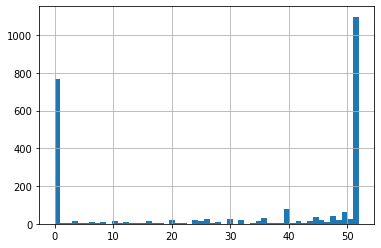

In [4]:
data_gss['WEEKSWRK'].hist(bins = 53)

However, treating it as a continuous variable is problematic. We now enforce `WEEKSWRK` to be treated as continuous when fitting the model and see what will happen.

In [5]:
weekswrk_index = np.flatnonzero('WEEKSWRK'==data_gss.columns).item()
model = GaussianCopula(verbose = 1, max_iter = 12)
Ximp = model.fit_transform(X=gss_masked, continuous = [weekswrk_index])

Iteration 1: copula parameter change 0.1496, likelihood -22.8607
Iteration 2: copula parameter change 0.0901, likelihood -22.7438
Iteration 3: copula parameter change 0.0604, likelihood -22.7255
Iteration 4: copula parameter change 0.0448, likelihood -22.7776
Iteration 5: copula parameter change 0.0356, likelihood -22.8732
Iteration 6: copula parameter change 0.0303, likelihood -22.9866
Iteration 7: copula parameter change 0.0285, likelihood -23.0983
Iteration 8: copula parameter change 0.0299, likelihood -23.1989
Iteration 9: copula parameter change 0.0336, likelihood -23.2893
Iteration 10: copula parameter change 0.0386, likelihood -23.3777
Iteration 11: copula parameter change 0.0434, likelihood -23.4771
Iteration 12: copula parameter change 0.0466, likelihood -23.6030
Convergence not achieved at maximum iterations


In [6]:
# verify WEEKSWRK is treated as continuous
for key,value in model.get_vartypes(feature_names = data_gss.columns.to_list()).items():
    print(f'{key}: {value}')

ordinal: ['DEGREE', 'PEOCNTCT', 'STRESS', 'SLPPRBLM', 'WKSMOOTH', 'UNEMP', 'SATFIN', 'CLASS', 'SATJOB', 'LIFE', 'HEALTH', 'HAPPY', 'RINCOME', 'INCOM16', 'SEXFREQ', 'SOCBAR']
continuous: ['WEEKSWRK', 'AGE']
lower_truncated: []
upper_truncated: []
twosided_truncated: []


As shown above, the algorithm diverges. Moreover, the likelihood which is expected to monotonically increase actually decreases after a few iterations. The reason is that 75% of `WEEKSWRK`'s population lies in either 0 or 52. Treating a variable with large mode multiplicity as a continuous variable severely violates the model's assumption on the input data. More specifically, the package will transform each continuous variable into a standard normal variable through some strict monotonic transformation. However, no strict monotonic transformation changes the multiplicity. The large mode multiplicity will remain after the transformation step and significantly violates the normality assumption, potentially causing the model's divergence.

Current implementation will no longer run into this problem: `WEEKSWRK` will be classified as a ordinal variable.

In [5]:
model = GaussianCopula(verbose = 1)
Ximp = model.fit_transform(X=gss_masked)

Iteration 1: copula parameter change 0.1453, likelihood -20.8997
Iteration 2: copula parameter change 0.0790, likelihood -20.6342
Iteration 3: copula parameter change 0.0449, likelihood -20.4840
Iteration 4: copula parameter change 0.0275, likelihood -20.3970
Iteration 5: copula parameter change 0.0181, likelihood -20.3441
Iteration 6: copula parameter change 0.0126, likelihood -20.3103
Iteration 7: copula parameter change 0.0091, likelihood -20.2877
Convergence achieved at iteration 7


In [6]:
# verify WEEKSWRK is treated as ordinal
for key,value in model.get_vartypes(feature_names = data_gss.columns.to_list()).items():
    print(f'{key}: {value}')

ordinal: ['DEGREE', 'PEOCNTCT', 'STRESS', 'SLPPRBLM', 'WKSMOOTH', 'UNEMP', 'SATFIN', 'CLASS', 'SATJOB', 'WEEKSWRK', 'LIFE', 'HEALTH', 'HAPPY', 'RINCOME', 'INCOM16', 'SEXFREQ', 'SOCBAR']
continuous: ['AGE']
lower_truncated: []
upper_truncated: []
twosided_truncated: []
